# Задание взято с [платформы](https://karpov.courses/)

Перед вами данные взаимодействий с рекламными объявлениями на некоторой площадке за 6 дней. И таблица с характеристиками рекламных клиентов (тех, кто разместил эти объявления).

### Задачи
1. Разберемся с распределением количества показов и кликов. Посчитайте среднее количество показов и среднее количество кликов на объявления за весь период (округлите до целых).
2. Нарисуйте график распределения показов на объявление за весь период.
3. Давайте посчитаем скользящее среднее показов с окном 2. Какое значение скользящего среднего получим за 6 апреля 2019 года (ответ округлите до целых)?
4. Скользящее среднее часто используется для поиска аномалий в данных. Давайте попробуем нанести на один график значения арифметического среднего по дням и скользящего среднего количества показов. В какой день наблюдается наибольшая разница по модулю между арифметическим средним и скользящим средним? Дни, в которых скользящее среднее равно NaN, не учитываем. 
5. *Напишите функцию, которая найдет проблемное объявление (с наибольшим/наименьшим количеством показов) в день, в который была замечена самая большая по модулю аномалия. 
6. Теперь подгрузим данные по рекламным клиентам и найдем среднее количество дней от даты создания рекламного клиента и первым запуском рекламного объявления этим клиентом.
7. Вычислите конверсию из создания рекламного клиента в запуск первой рекламы в течение не более 365 дней. Ответ дайте в процентах и округлите до сотых. (Фильтровать нужно по значению в формате pd.Timedelta(365, unit='d'))
8. Давайте разобъем наших клиентов по промежуткам от создания до запуска рекламного объявления, равным 30. Определите, сколько уникальных клиентов запустили свое первое объявление в первый месяц своего существования (от 0 до 30 дней). Список промежутков для метода pd.cut – [0, 30, 90, 180, 365]
9. А теперь – выведем на интерактивный график эти категории с количеством уникальных клиентов в них.

### Описание данных
<font color='red'>`ads_data.csv`</font>  – данные взаимодействий с рекламными объявлениями

<span style="color:red">`ads_data.csv`</span>

- `date` – дата
- `time` – время
- `event` – действие (просмотр/клик)
- `platform` – платформа
- `ad_id` – id объявления
- `client_union_id` – id рекламного кабинета
- `campaign_union_id` – id рекламной кампании
- `ad_cost_type` – тип оплаты
- `ad_cost` – цена
- `has_video` – есть ли видео
- `target_audience_count` – размер аудитории


`ads_clients_data.csv` – характеристики рекламных клиентов

- `date` – дата
- `client_union_id` – id рекламного кабинета
- `community_id` – id сообщества
- `create_date` – дата создания рекламного клиента

In [1]:
# Для начала импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px


In [52]:
# И устанавливаем настройки для графиков в ноутбуке
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(10,4)}
        )

In [3]:
# Считываем файлики и проверяем их
ads_data         = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-otvetchikov/Python/Lesson_6/ads_data.csv')
ads_clients_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-otvetchikov/Python/Lesson_6/ads_clients_data.csv')                      
                       

In [4]:
ads_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


In [5]:
ads_data.dtypes

date                      object
time                      object
event                     object
platform                  object
ad_id                      int64
client_union_id            int64
campaign_union_id          int64
ad_cost_type              object
ad_cost                  float64
has_video                  int64
target_audience_count      int64
dtype: object

In [6]:
ads_clients_data.head()

,date,client_union_id,community_id,create_date
0,2020-05-07,1,-130371893,2018-12-24
1,2020-05-07,2,-130304626,2019-02-10
2,2020-05-07,3,-130462599,2019-01-25
3,2020-05-07,4,-130574300,2018-12-09
4,2020-05-07,5,-130292358,2019-01-08


Для начала посчитаем среднее количество разных рекламных событий (показы и клики) по объявлениям. Тонкий момент: помните, что некоторые показываемые объявления не кликались, и при группировке в таких случаях не будет строк с кликами, а для подсчёта среднего по объявлениям их нужно учитывать. Округлите ответы до целых чисел.

In [7]:
ads_data_event = ads_data.groupby(['ad_id', 'event'], as_index=False) \
        .agg({"platform": "count"}) \
        .pivot(index='ad_id', columns='event', values='platform')
ads_data_event.fillna(0).reset_index().mean()

event
ad_id    57971.024870
click      113.137824
view       923.131606
dtype: float64

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


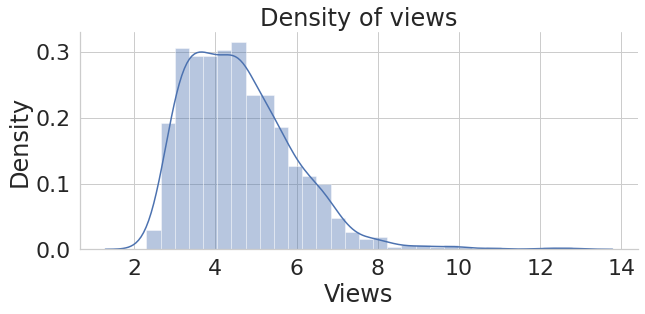

In [53]:
ax = sns.distplot(np.log(ads_data_event['view']))
ax.set_title('Density of views')
ax.set_xlabel('Views')

sns.despine()

Теперь нужно найти среднее количество показов на 1 объявление (`ad_id`) по дням, не учитывая объявления, у которых не было показов (обычное среднее). После этого посчитайте скользящее среднее по полученному результату с окном в 2 элемента.

Вопрос: Какое значение скользящего среднего получим за 6 апреля 2019 года? Округлите ответ до целого числа.

In [9]:
ads_data_views_rolling = ads_data[ads_data['event']== 'view'].groupby(['ad_id', 'date'], as_index=[False, False]) \
    .agg({'platform': 'count'}).reset_index() \
    .groupby('date') \
    .agg({'platform': 'mean'}) \
    .rolling(2).mean().round()

Скользящее среднее часто используется для поиска аномалий в данных. Давайте попробуем нанести на один график значения просто среднего количества показов по дням и скользящего среднего на основе этих данных (которое мы получили в прошлом задании).

Посчитайте, в какой день наблюдается наибольшая разница по модулю между арифметическим средним и скользящим средним? Дни, в которых скользящее среднее равно NaN, не учитываем. 


In [10]:
ads_data_views_mean = ads_data[ads_data['event']== 'view'].groupby(['ad_id', 'date'], as_index=[False, False]) \
    .agg({'platform': 'count'}).reset_index() \
    .groupby('date') \
    .agg({'platform': 'mean'})

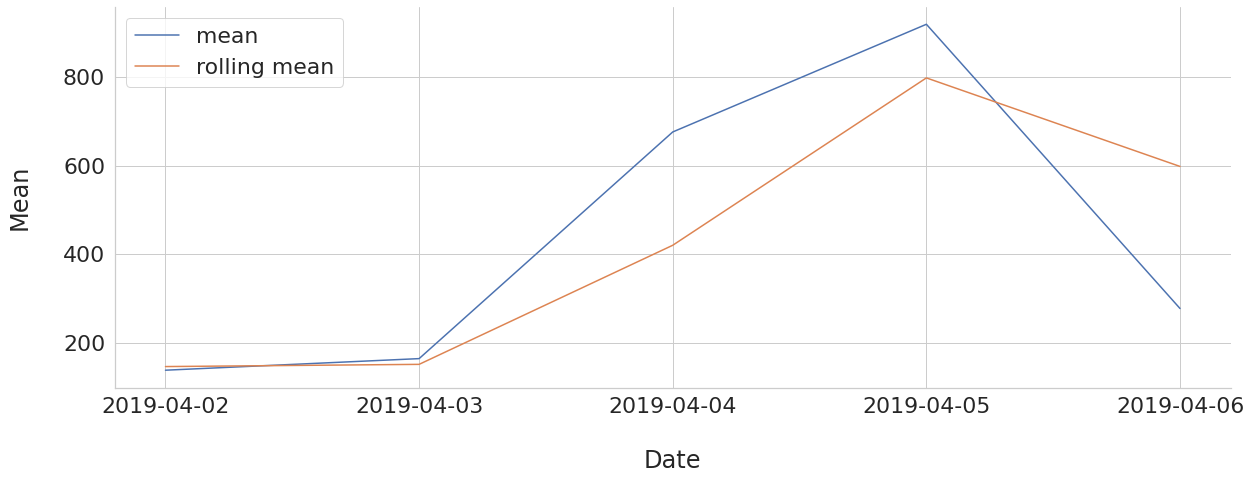

In [11]:
sns.lineplot(data=ads_data_views_mean.reset_index()[1:], x='date', y='platform')
sns.lineplot(data=ads_data_views_rolling.reset_index()[1:], x='date', y='platform')
plt.legend(loc='upper left', labels=['mean', 'rolling mean'])
plt.ylabel('Mean\n')
plt.xlabel('\nDate')
sns.despine()

In [12]:
abs(ads_data_views_mean-ads_data_views_rolling)

,platform
date,
2019-04-01,NaN
2019-04-02,8.213018
2019-04-03,12.952778
2019-04-04,255.901720
2019-04-05,121.109677
2019-04-06,320.877273


Объедините данные рекламы с данными о рекламных клиентах и найдите среднее количество дней от даты создания рекламного клиента (`create_date`) и первым запуском рекламного объявления этим клиентом (`date`).

В качестве ответа укажите среднее число дней.

In [36]:
merged_df = ads_data.merge(ads_clients_data.drop('date', axis=1), on='client_union_id', how='inner')

merged_df['date']        = pd.to_datetime(merged_df['date'])
merged_df['create_date'] = pd.to_datetime(merged_df['create_date'])


In [37]:
merged_df.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count,community_id,create_date
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269,-130129582,2018-12-04
1,2019-04-01,2019-04-01 00:03:28,view,android,45061,34734,45061,CPM,200.6,0,1955269,-130129582,2018-12-04
2,2019-04-01,2019-04-01 00:04:58,view,ios,45061,34734,45061,CPM,200.6,0,1955269,-130129582,2018-12-04
3,2019-04-01,2019-04-01 00:10:23,view,ios,45061,34734,45061,CPM,200.6,0,1955269,-130129582,2018-12-04
4,2019-04-01,2019-04-01 00:15:42,view,android,45061,34734,45061,CPM,200.6,0,1955269,-130129582,2018-12-04


In [38]:
merged_df.dtypes

date                     datetime64[ns]
time                             object
event                            object
platform                         object
ad_id                             int64
client_union_id                   int64
campaign_union_id                 int64
ad_cost_type                     object
ad_cost                         float64
has_video                         int64
target_audience_count             int64
community_id                      int64
create_date              datetime64[ns]
dtype: object

In [39]:
merged_df['between_dates'] = merged_df['date'] - merged_df['create_date']
    

In [43]:
merged_df.groupby('client_union_id') \
    .agg({'between_dates':'min'}).mean()

between_dates   124 days 09:04:43.532219570
dtype: timedelta64[ns]

Давайте вычислим конверсию из создания рекламного кабинета в запуск первой рекламы в течение не более 365 дней.

Конверсия – отношение числа клиентов, которые совершили целевое действие (создали рекламу), к общему числу клиентов.

In [61]:
#Для начала отберем всех клиентов, которые запустили рекламу не позже года
clients_with_campaign = merged_df[merged_df['between_dates'] < pd.Timedelta(365, unit='day')] \
    .groupby('client_union_id') \
    .agg({'campaign_union_id': 'count'})


clients_with_campaign.head()

,campaign_union_id
client_union_id,
1,289
9,42
13,35
16,59
20,3412


In [62]:
# всего их 838 человек
len(clients_with_campaign)

838

In [63]:
# А теперь посмотрим сколько всего у нас есть клиентов. Их чуть больше, чем мы думали...
ads_clients_data.client_union_id.nunique()

122078

In [66]:
# Осталось рассчитать искомую метрику
round((len(clients_with_campaign)/ads_clients_data.client_union_id.nunique()*100), 2)

0.69

In [56]:
merged_df.client_union_id.nunique()

838

Давайте разобъем наших клиентов по промежуткам от создания рекламного кабинета до запуска первого рекламного объявления.

Определите, сколько уникальных клиентов запустили свое первое объявление в первый месяц своего существования (от 0 до 30 дней). 

In [94]:
plot_df = pd.DataFrame({'interval_days': pd.cut(merged_df.groupby('client_union_id').agg({"between_dates": "min"})['between_dates'],
       bins=pd.to_timedelta(["0 days", "30 days", "90 days", '180 days', "365 days", "1999 days"]),
       labels=["less than 30 days", "30-90 days", "90-180 days", "180-365 days", "more than 365 days"])}).value_counts()

И последнее задание: постройте интерактивный барплот, на котором будут показаны категории с количеством уникальных клиентов в них (то, что у вас получилось на прошлом степе, по запуску первого рекламного объявления). Расположите их так, чтобы внизу была самая малочисленная, а наверху – самая большая.

In [105]:
fig = px.bar(plot_df.reset_index(), x='interval_days', y=0, title="Количество клиентов, запустивших рекламу в указанный период", 
            labels={'0':'Count of client'})

fig.show()

## Дополнительный проект
В данном проекте вы поработаете с довольно нетипичными для аналитика данными: gff файлом, который описывает геном мухи (описание формата можно найти [здесь](http://gmod.org/wiki/GFF3)). При его выполнении вам может понадобиться часть конспекта про работу со строковыми данными, а именно – про строковые методы серий.

### Задачи
- Выделите из колонки `attributes` значение атрибута Parent. Т.е. если там записано Parent=x, то нам нужен x
- Выясните, какое из этих значений является самым частым
- Постройте распределение встречаемости значений в столбце type

In [108]:
gff = pd.read_csv('gff.tsv', sep="\t")

In [113]:
gff

,seq_id,source,type,start,end,score,strand,phase,attributes
0,chr17,RefSeq,exon,6811330,6811453,.,+,.,Parent=XM_001475631.1
1,chr17,RefSeq,CDS,6808204,6808245,.,+,0,Name=CDS:NC_000083.5:LOC100040603;Parent=XM_00...
2,chr17,RefSeq,CDS,6811792,6811869,.,+,2,Name=CDS:NC_000083.5:LOC100040603;Parent=XM_00...
3,chr17,RefSeq,exon,6806513,6806553,.,+,.,Parent=XM_001475631.1
4,chr17,RefSeq,five_prime_UTR,6806513,6806526,.,+,.,Parent=XM_001475631.1
...,...,...,...,...,...,...,...,...,...
507,chr17,RefSeq,exon,6812219,6818159,.,+,.,Parent=XM_001475631.1
508,chr17,RefSeq,protein,6806527,6812289,.,+,.,ID=;Parent=XM_001475631.1
509,chr17,RefSeq,CDS,6806527,6806553,.,+,0,Name=CDS:NC_000083.5:LOC100040603;Parent=XM_00...
510,chr17,RefSeq,exon,6811792,6811869,.,+,.,Parent=XM_001475631.1


In [115]:
gff.dtypes

seq_id        object
source        object
type          object
start          int64
end            int64
score         object
strand        object
phase         object
attributes    object
dtype: object

Какое значение атрибута `Parent` самое частое?

In [117]:
import re

In [132]:
gff['parent'] = [re.search(r'Parent=\S+', gff.attributes[i])[0][7:].replace(',', '') for i in range(len(gff))]

In [133]:
gff['parent'].value_counts()

XM_001475631.1              479
NC_000083.5:LOC100040603     33
Name: parent, dtype: int64

Какое самое частое значение в колонке `type`?

In [134]:
gff.type.value_counts()

exon               201
CDS                170
five_prime_UTR      47
mRNA                33
three_prime_UTR     32
protein             29
Name: type, dtype: int64